### Problem Statement
[insert]


### Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# https://data.ny.gov/Transportation/Turnstile-Usage-Data-2016/ekwu-khcy
# https://data.ny.gov/api/views/ekwu-khcy/rows.csv?accessType=DOWNLOAD
data = pd.read_csv('Turnstile_Usage_Data__2016.csv')
data = pd.DataFrame(data) # change to pandas dataframe
# parse spaces from columns; to use better approach when 
data=data.rename(columns = {'Exits                                                     ':'Exits'})
# Do we need to convert Date column to datetime?
# data['Date'] = data['Date'].to_datetime()
# data['Date'] = data['Date'].dt.date


/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# data['Date'] = data['Date'].astype('datetime64') # convert data column to date type
# print(type(data['Date']))
# remove first few columns, deemed irrelevant
data = data.iloc[:,3:]
data.head()

,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,59 ST,NQR456,BMT,03/04/2016,23:00:00,REGULAR,5572864,1881239
1,59 ST,NQR456,BMT,03/04/2016,19:00:00,REGULAR,5572521,1881206
2,59 ST,NQR456,BMT,03/04/2016,15:00:00,REGULAR,5571587,1881113
3,59 ST,NQR456,BMT,03/04/2016,11:00:00,REGULAR,5571313,1881031
4,59 ST,NQR456,BMT,03/04/2016,08:10:05,REGULAR,5571173,1880736


### Process Data

In [4]:
# Groupby Station, Day
data = data.groupby(["Station", "Date"],as_index=False).max() # sort by station, date
data = pd.DataFrame(data)
data.head()

,Station,Date,Description,Division,Entries,Exits,Time
0,1 AV,01/02/2016,REGULAR,BMT,952276833,996873524,23:00:00
1,1 AV,01/03/2016,REGULAR,BMT,952278811,996874582,23:00:00
2,1 AV,01/04/2016,REGULAR,BMT,952281200,996876891,23:00:00
3,1 AV,01/05/2016,REGULAR,BMT,952283626,996879260,23:00:00
4,1 AV,01/06/2016,REGULAR,BMT,952286534,996881553,23:00:00


In [5]:
# Data presented as cumulative; add columns to track the increment
# Add Traffic_Tot column as sum of Entry and Exit to represent activity
data['Entry_Inc'] = abs(data.Entries.diff())
# data['Entry_Inc2'] = data['Entry_Inc']

data['Exits_Inc'] = abs(data.Exits.diff())
data['Traffic_Tot'] = np.add(data.Entry_Inc, data.Exits_Inc)
data.head()

,Station,Date,Description,Division,Entries,Exits,Time,Entry_Inc,Exits_Inc,Traffic_Tot
0,1 AV,01/02/2016,REGULAR,BMT,952276833,996873524,23:00:00,NaN,NaN,NaN
1,1 AV,01/03/2016,REGULAR,BMT,952278811,996874582,23:00:00,1978.0,1058.0,3036.0
2,1 AV,01/04/2016,REGULAR,BMT,952281200,996876891,23:00:00,2389.0,2309.0,4698.0
3,1 AV,01/05/2016,REGULAR,BMT,952283626,996879260,23:00:00,2426.0,2369.0,4795.0
4,1 AV,01/06/2016,REGULAR,BMT,952286534,996881553,23:00:00,2908.0,2293.0,5201.0


In [6]:
# filter outliers above specified quantile
quant_filt = 0.99
q = data["Entry_Inc"].quantile(quant_filt)
data = data[data["Entry_Inc"] < q]

r = data["Exits_Inc"].quantile(quant_filt)
data = data[data["Exits_Inc"] < r]

s = data["Traffic_Tot"].quantile(quant_filt)
data = data[data["Traffic_Tot"] < s]

# data = data.dropna() # apparently no issues with NaN cells; running as best practice

data.head()

,Station,Date,Description,Division,Entries,Exits,Time,Entry_Inc,Exits_Inc,Traffic_Tot
1,1 AV,01/03/2016,REGULAR,BMT,952278811,996874582,23:00:00,1978.0,1058.0,3036.0
2,1 AV,01/04/2016,REGULAR,BMT,952281200,996876891,23:00:00,2389.0,2309.0,4698.0
3,1 AV,01/05/2016,REGULAR,BMT,952283626,996879260,23:00:00,2426.0,2369.0,4795.0
4,1 AV,01/06/2016,REGULAR,BMT,952286534,996881553,23:00:00,2908.0,2293.0,5201.0
5,1 AV,01/07/2016,REGULAR,BMT,952289459,996883685,23:00:00,2925.0,2132.0,5057.0


### Sort Data
Data is sorted by Station.

In [7]:
# data_stndatetime = data.groupby([ "Station", "Date",'Time']).sum() # sort by station, date and time
# data_stndatetime.head()

In [8]:
data_stn = data.groupby([ "Station"]).sum() # sort by station
# data_stn = pd.DataFrame(data_stn) # convert to panda dataframe
data_stn['Station_ID'] = data_stn.index # Make Station_ID a non-index column
data_stn = data_stn.sort_values(['Traffic_Tot'], ascending=[False]) # Sort stations by traffic
data_stn['Idx'] = np.arange(data_stn.shape[0]) # add enumerated column
data_stn = data_stn.set_index('Idx') # assign enumerated column as index column
data_stn.head()

,Entries,Exits,Entry_Inc,Exits_Inc,Traffic_Tot,Station_ID
Idx,,,,,,
0,5253497403,5851296832,1078229.0,855806.0,1934035.0,BROADWAY JCT
1,4936512760,2215709680,597726.0,1326612.0,1924338.0,ASTOR PL
2,6020755303,4746892524,1064578.0,815432.0,1880010.0,61 ST WOODSIDE
3,4118410940,6765530103,872305.0,987015.0,1859320.0,MYRTLE AV
4,515455449736,678082494750,1171455.0,664099.0,1835554.0,34 ST-HERALD SQ


## Prep Data for Charting

In [9]:
# demographic data: NYC census
# map of startups in NYC
# calendar of tech events
# unicorn 

# import seaborn as sns
sns.set_style("whitegrid")


In [10]:
data_stn = data_stn.iloc[:20,:] # limit to 20 most active stations

data_stn.head()


,Entries,Exits,Entry_Inc,Exits_Inc,Traffic_Tot,Station_ID
Idx,,,,,,
0,5253497403,5851296832,1078229.0,855806.0,1934035.0,BROADWAY JCT
1,4936512760,2215709680,597726.0,1326612.0,1924338.0,ASTOR PL
2,6020755303,4746892524,1064578.0,815432.0,1880010.0,61 ST WOODSIDE
3,4118410940,6765530103,872305.0,987015.0,1859320.0,MYRTLE AV
4,515455449736,678082494750,1171455.0,664099.0,1835554.0,34 ST-HERALD SQ


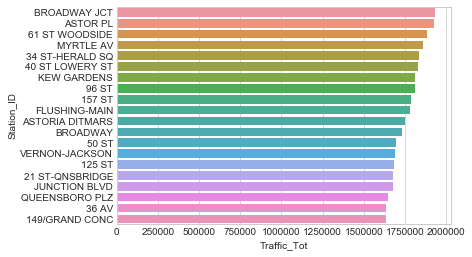

In [11]:
# verify results: check http://web.mta.info/nyct/facts/ffsubway.htm
ax = sns.barplot(x="Traffic_Tot", y='Station_ID', data=data_stn)
# gut feeling is that 23rd St is not a top station.  If more time, would
# further analyze 23rd Street for outliers.


In [12]:
# PROBLEM STATEMENT
# Optimize utilization of street teams by using data science by utilizing MTA 
# and [Demographic] data

# PRESENTATION
# Executive Summary / Scenario
# MTA findings
# Demographic findings
# Combined MTA/Demo Analysis
# Conclusion
# Q&A

# TODO:
# Clean up JN
# day/hour analyses
# combine demographic data
# Map which includes demographic data (ie income) and station activity (by size of dot)
# Analyze top stations by time period (season, month, week, day, hour)
# add lat/long
# vet data better / graph 

# Tomorrow morning
# Finished pres, practice

### Top Station Activity: Penn Station 34th Street

In [13]:
data_Penn = data[data['Station'] == '34 ST-PENN STA']
# data_Penn.head()
np.max(data_Penn['Traffic_Tot'])


7013.0

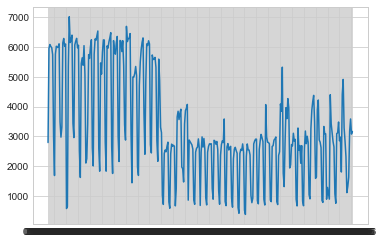

In [14]:
y = pd.Series(data_Penn['Traffic_Tot'])
x = pd.Series(data_Penn['Date'])

plt.plot(x,y)
# axes = plt.gca()
# axes.set_ylim([1000,2000])
plt.show()

### Top Station Activity: 23rd St

In [15]:
data_23ST = data[data['Station'] == '23 ST']
# data_23ST.head()
np.max(data_23ST['Traffic_Tot'])


5413.0

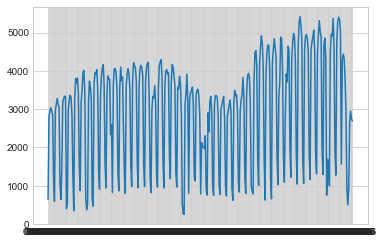

In [16]:
y = pd.Series(data_23ST['Traffic_Tot'])
x = pd.Series(data_23ST['Date'])

plt.plot(x,y)
# axes = plt.gca()
# axes.set_ylim([1000,2000])
plt.show()

### Top Station Activity: 72nd St

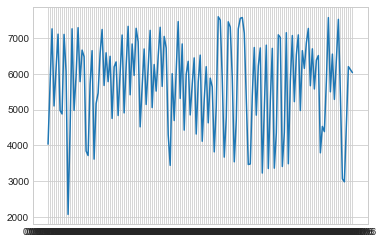

In [17]:
data_72ST = data[data['Station'] == '72 ST']
y = pd.Series(data_72ST['Traffic_Tot'])
x = pd.Series(data_72ST['Date'])

plt.plot(x,y)
# axes = plt.gca()
# axes.set_ylim([1000,2000])
plt.show()

In [18]:
data = pd.DataFrame(data)
data['Date'] = pd.to_datetime(data['Date'])
type(data['Date'])

pandas.core.series.Series